# CNN
Convolutional Neural Network. It can effectively filter out the noise in a timeseries with the convolution operation. They are also usually faster to train than LSTM. The convolutional operation reduces the set of features by using a filter/kernel that is slid across the input features. We will use only a 1-D filter as we only have a single dimension which is time. We also apply padding to not loose too musch information from convolutions (usually we just pad with the value, 0).

## Loading the prerequisites

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [2]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [13]:
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('data/train.csv', index_col=0)
val_df = pd.read_csv('data/val.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Inplementing the CNN

For each of the following types we will also combine the CNN architecture with the LSTM architecture by using a LSTM unit in our model. We do this to check if we observe any changes.

### Single-step CNN model

In [9]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

In [10]:
conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [11]:
mae_val = [0.083, 0.066, 0.032, 0.026]
mae_test = [0.081, 0.063, 0.032, 0.024]

In [14]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

In [15]:
history = compile_and_fit(cnn_model, conv_window)

Epoch 1/50
384/384 [==============================] - 10s 12ms/step - loss: 0.0146 - mean_absolute_error: 0.0819 - val_loss: 0.0049 - val_mean_absolute_error: 0.0537
Epoch 2/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0505 - val_loss: 0.0032 - val_mean_absolute_error: 0.0427
Epoch 3/50
384/384 [==============================] - 3s 8ms/step - loss: 0.0034 - mean_absolute_error: 0.0432 - val_loss: 0.0027 - val_mean_absolute_error: 0.0378
Epoch 4/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0399 - val_loss: 0.0022 - val_mean_absolute_error: 0.0343
Epoch 5/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0028 - mean_absolute_error: 0.0383 - val_loss: 0.0021 - val_mean_absolute_error: 0.0334
Epoch 6/50
384/384 [==============================] - 4s 10ms/step - loss: 0.0025 - mean_absolute_error: 0.0359 - val_loss: 0.0020 - val_mean_absolute_error: 0.0325
Epoch 7/50
3

In [16]:
val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

110/110 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0319


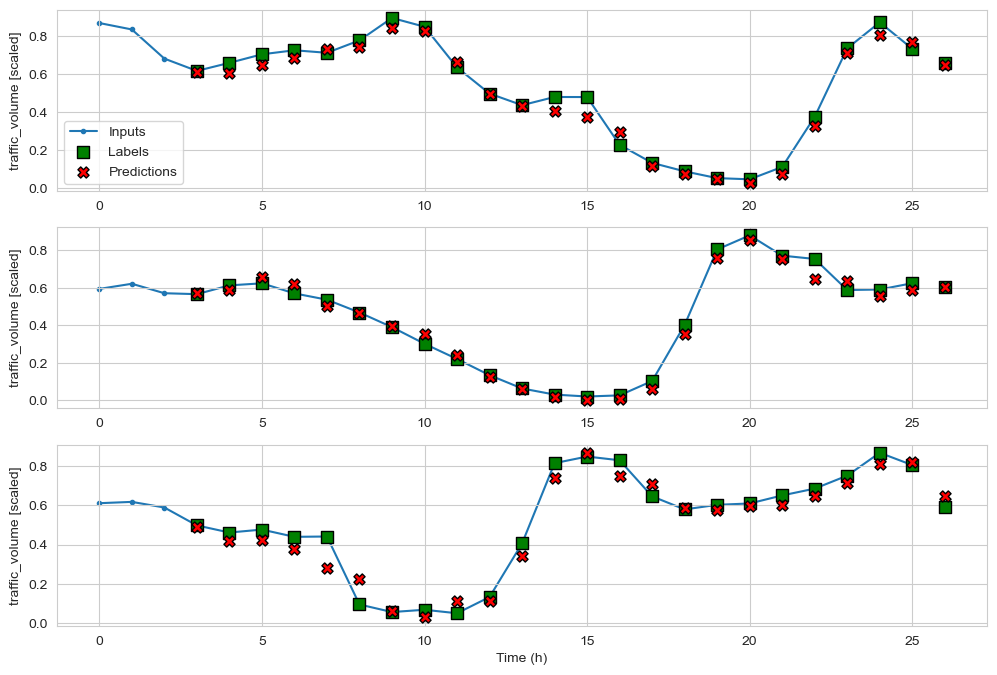

In [17]:
wide_conv_window.plot(cnn_model)

### Single-step CNN + LSTM model

In [18]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True), #we add LSTM layers
    LSTM(32, return_sequences=True), #we add LSTM layers
    Dense(1)
])

In [19]:
history = compile_and_fit(cnn_lstm_model, conv_window)

Epoch 1/50
384/384 [==============================] - 22s 19ms/step - loss: 0.0324 - mean_absolute_error: 0.1222 - val_loss: 0.0080 - val_mean_absolute_error: 0.0645
Epoch 2/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0073 - mean_absolute_error: 0.0628 - val_loss: 0.0061 - val_mean_absolute_error: 0.0577
Epoch 3/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0058 - mean_absolute_error: 0.0558 - val_loss: 0.0050 - val_mean_absolute_error: 0.0514
Epoch 4/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0048 - mean_absolute_error: 0.0506 - val_loss: 0.0038 - val_mean_absolute_error: 0.0457
Epoch 5/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0041 - mean_absolute_error: 0.0466 - val_loss: 0.0039 - val_mean_absolute_error: 0.0465
Epoch 6/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0036 - mean_absolute_error: 0.0437 - val_loss: 0.0039 - val_mean_absolute_error: 0.0495
Epoch 7/5

In [20]:
val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

110/110 [==============================] - 1s 9ms/step - loss: 0.0020 - mean_absolute_error: 0.0330


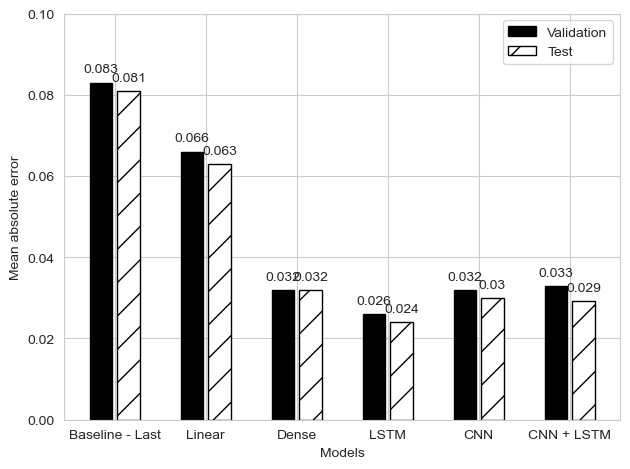

In [21]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

* As we can see, the CNN models are actually worse than the LSTM model.
* This could may be due to the fact that we only provide an input sequence of 3 values which may not be suffecient ot extract valuable features for predictions.

### Multi-step CNN model

In [22]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

In [23]:
multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [37]:
ms_mae_val = [0.353, 0.247, 0.089, 0.074, 0.067]
ms_mae_test = [0.348, 0.238, 0.077, 0.06, 0.057]

In [25]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

In [26]:
history = compile_and_fit(ms_cnn_model, multi_window)

Epoch 1/50
383/383 [==============================] - 10s 15ms/step - loss: 0.0315 - mean_absolute_error: 0.1172 - val_loss: 0.0166 - val_mean_absolute_error: 0.0847
Epoch 2/50
383/383 [==============================] - 5s 12ms/step - loss: 0.0144 - mean_absolute_error: 0.0799 - val_loss: 0.0156 - val_mean_absolute_error: 0.0831
Epoch 3/50
383/383 [==============================] - 5s 12ms/step - loss: 0.0137 - mean_absolute_error: 0.0781 - val_loss: 0.0154 - val_mean_absolute_error: 0.0859
Epoch 4/50
383/383 [==============================] - 4s 9ms/step - loss: 0.0133 - mean_absolute_error: 0.0768 - val_loss: 0.0146 - val_mean_absolute_error: 0.0787
Epoch 5/50
383/383 [==============================] - 4s 10ms/step - loss: 0.0131 - mean_absolute_error: 0.0759 - val_loss: 0.0146 - val_mean_absolute_error: 0.0824
Epoch 6/50
383/383 [==============================] - 4s 9ms/step - loss: 0.0128 - mean_absolute_error: 0.0750 - val_loss: 0.0140 - val_mean_absolute_error: 0.0786
Epoch 7/50


In [27]:
ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 6ms/step - loss: 0.0122 - mean_absolute_error: 0.0705


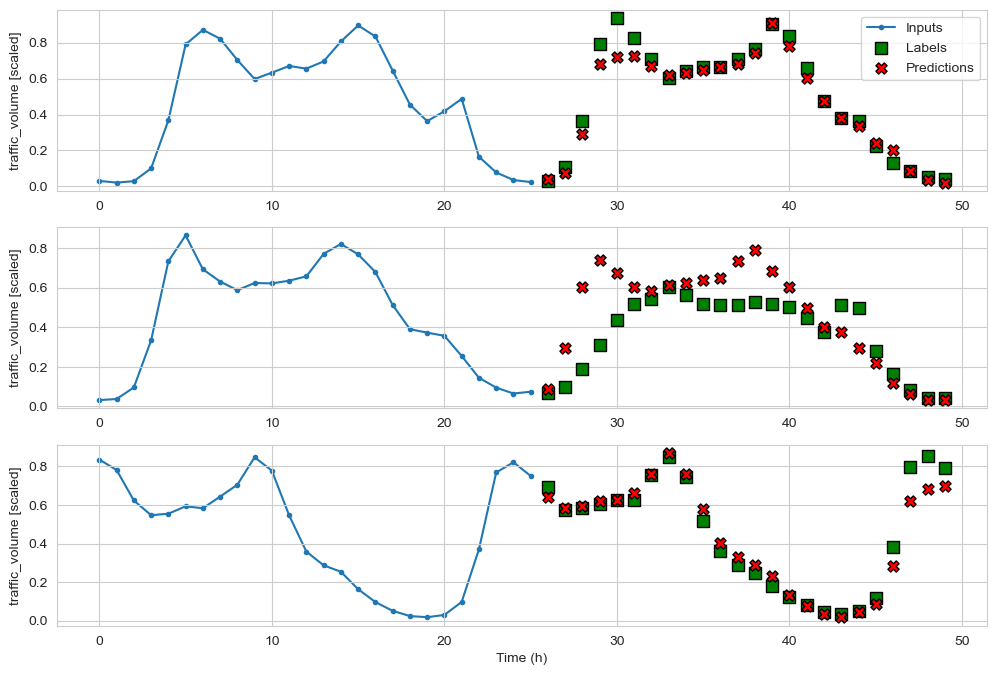

In [28]:
multi_window.plot(ms_cnn_model)

### Multi-step CNN + LSTM model

In [29]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

In [30]:
history = compile_and_fit(ms_cnn_lstm_model, multi_window)

Epoch 1/50
383/383 [==============================] - 28s 39ms/step - loss: 0.0339 - mean_absolute_error: 0.1254 - val_loss: 0.0166 - val_mean_absolute_error: 0.0867
Epoch 2/50
383/383 [==============================] - 11s 28ms/step - loss: 0.0145 - mean_absolute_error: 0.0818 - val_loss: 0.0159 - val_mean_absolute_error: 0.0845
Epoch 3/50
383/383 [==============================] - 11s 28ms/step - loss: 0.0137 - mean_absolute_error: 0.0779 - val_loss: 0.0150 - val_mean_absolute_error: 0.0810
Epoch 4/50
383/383 [==============================] - 11s 28ms/step - loss: 0.0129 - mean_absolute_error: 0.0751 - val_loss: 0.0145 - val_mean_absolute_error: 0.0757
Epoch 5/50
383/383 [==============================] - 11s 29ms/step - loss: 0.0126 - mean_absolute_error: 0.0737 - val_loss: 0.0143 - val_mean_absolute_error: 0.0791
Epoch 6/50
383/383 [==============================] - 11s 29ms/step - loss: 0.0121 - mean_absolute_error: 0.0719 - val_loss: 0.0137 - val_mean_absolute_error: 0.0771
Epoc

In [31]:
ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 2s 20ms/step - loss: 0.0114 - mean_absolute_error: 0.0649


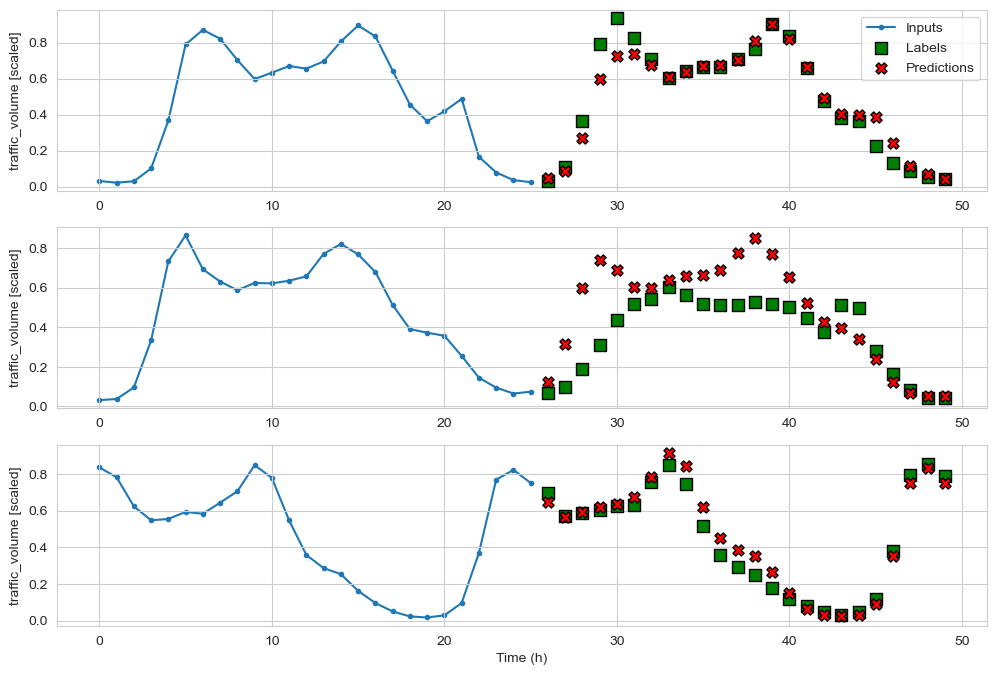

In [32]:
multi_window.plot(ms_cnn_lstm_model)

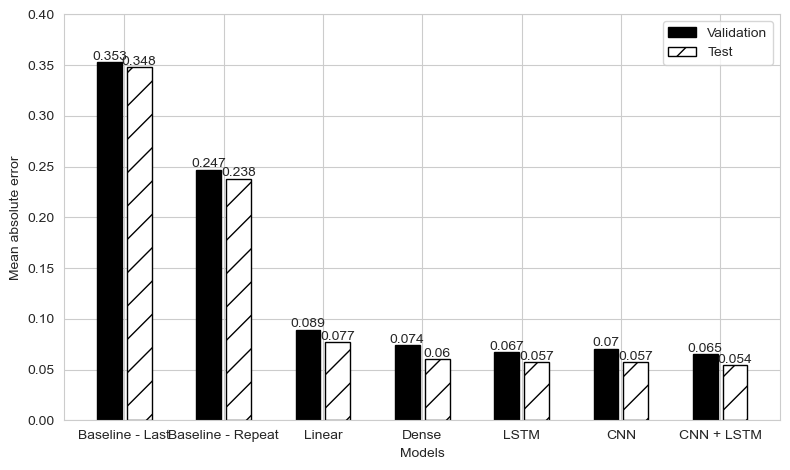

In [38]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
fig.set_figwidth(8)
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

* Here we can see that the CNN model is worse than the LSTM model.
* However, the combined model is slightly better than the LSTM model.

### Multi-output CNN model

In [39]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

In [40]:
wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [41]:
mo_mae_val = [0.048, 0.038, 0.021, 0.02]
mo_mae_test = [0.047, 0.036, 0.019, 0.018]

In [42]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

In [43]:
history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

Epoch 1/50
384/384 [==============================] - 7s 10ms/step - loss: 0.0314 - mean_absolute_error: 0.1011 - val_loss: 0.0034 - val_mean_absolute_error: 0.0388
Epoch 2/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0027 - mean_absolute_error: 0.0340 - val_loss: 0.0019 - val_mean_absolute_error: 0.0303
Epoch 3/50
384/384 [==============================] - 5s 14ms/step - loss: 0.0020 - mean_absolute_error: 0.0291 - val_loss: 0.0016 - val_mean_absolute_error: 0.0269
Epoch 4/50
384/384 [==============================] - 3s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0258 - val_loss: 0.0012 - val_mean_absolute_error: 0.0235
Epoch 5/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0014 - mean_absolute_error: 0.0238 - val_loss: 0.0011 - val_mean_absolute_error: 0.0219
Epoch 6/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0014 - mean_absolute_error: 0.0228 - val_loss: 0.0010 - val_mean_absolute_error: 0.0213
Epoch 7/50
3

In [44]:
mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

109/109 [==============================] - 1s 8ms/step - loss: 9.2179e-04 - mean_absolute_error: 0.0193


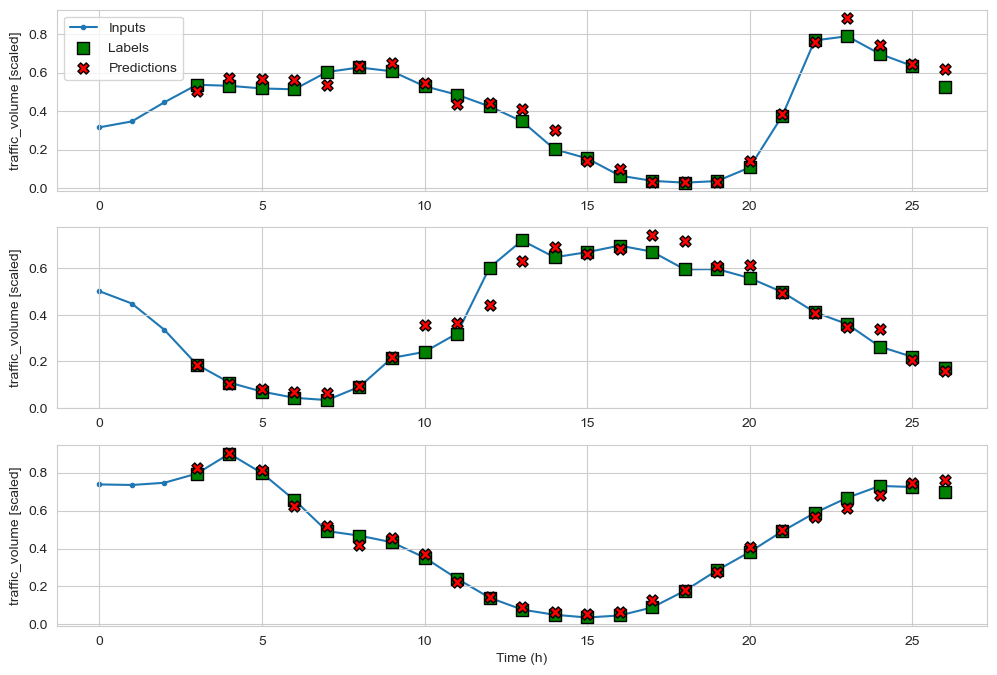

In [45]:
wide_mo_conv_window.plot(mo_cnn_model)

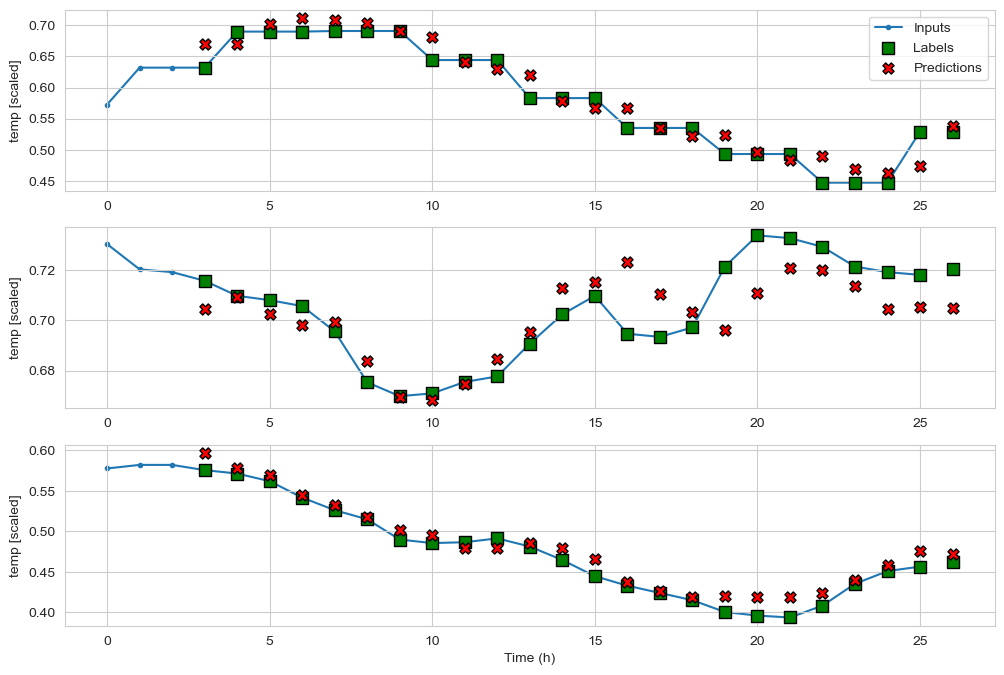

In [46]:
wide_mo_conv_window.plot(mo_cnn_model, plot_col='temp')

### Multi-output CNN + LSTM model

In [47]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

In [48]:
history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

Epoch 1/50
384/384 [==============================] - 27s 30ms/step - loss: 0.0201 - mean_absolute_error: 0.0877 - val_loss: 0.0040 - val_mean_absolute_error: 0.0423
Epoch 2/50
384/384 [==============================] - 10s 27ms/step - loss: 0.0031 - mean_absolute_error: 0.0373 - val_loss: 0.0022 - val_mean_absolute_error: 0.0326
Epoch 3/50
384/384 [==============================] - 11s 28ms/step - loss: 0.0022 - mean_absolute_error: 0.0312 - val_loss: 0.0016 - val_mean_absolute_error: 0.0278
Epoch 4/50
384/384 [==============================] - 11s 27ms/step - loss: 0.0018 - mean_absolute_error: 0.0284 - val_loss: 0.0014 - val_mean_absolute_error: 0.0258
Epoch 5/50
384/384 [==============================] - 11s 27ms/step - loss: 0.0017 - mean_absolute_error: 0.0268 - val_loss: 0.0016 - val_mean_absolute_error: 0.0282
Epoch 6/50
384/384 [==============================] - 11s 28ms/step - loss: 0.0016 - mean_absolute_error: 0.0255 - val_loss: 0.0012 - val_mean_absolute_error: 0.0231
Epoc

In [49]:
mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0) 

109/109 [==============================] - 1s 5ms/step - loss: 9.2179e-04 - mean_absolute_error: 0.0193


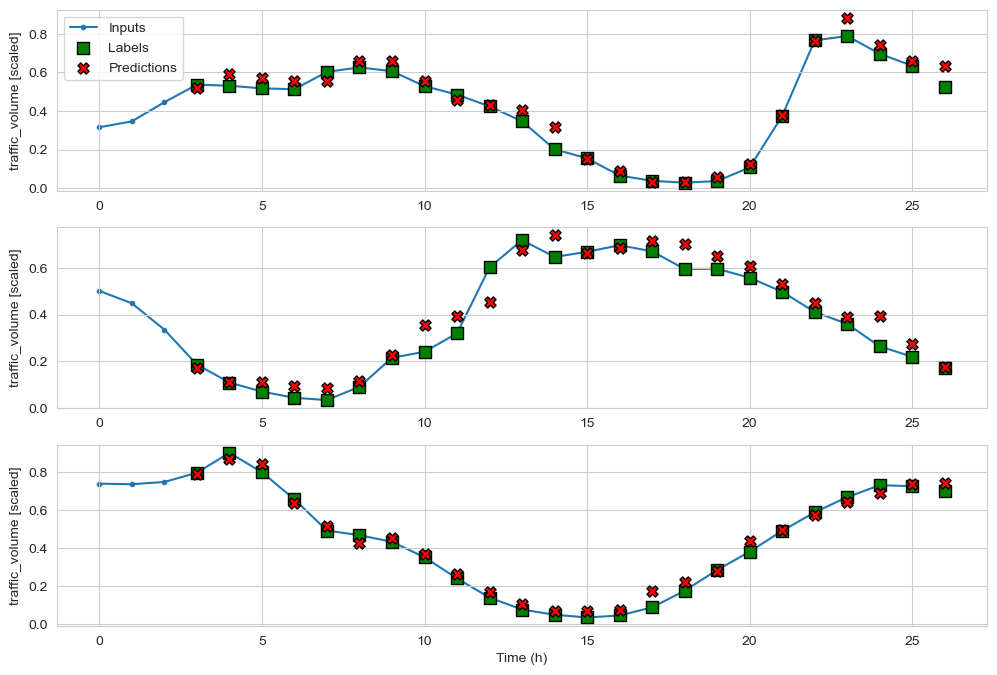

In [50]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

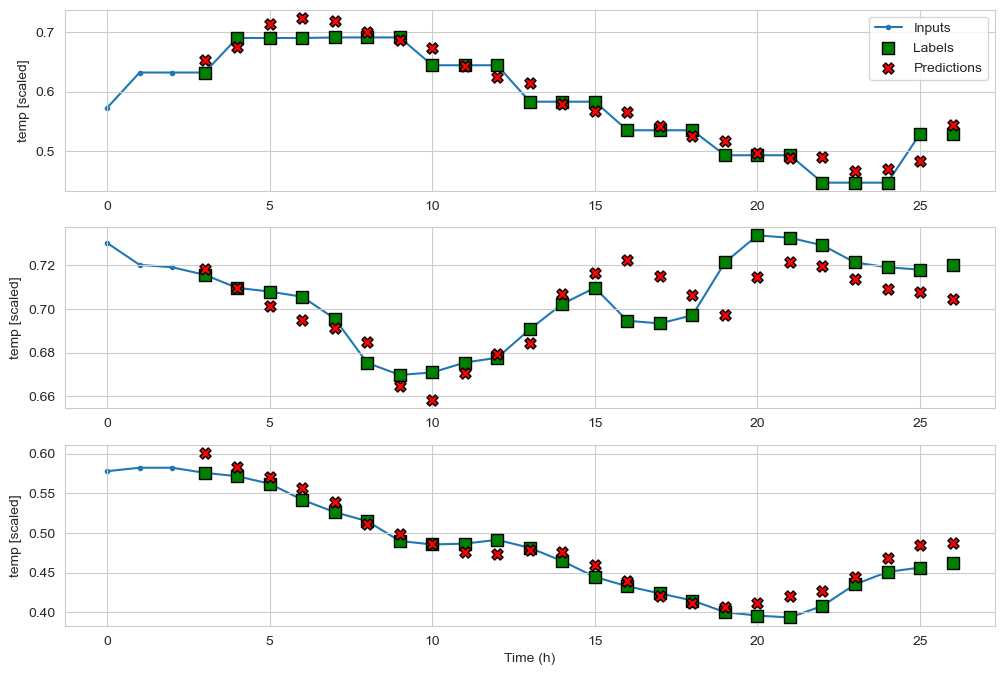

In [51]:
wide_mo_conv_window.plot(mo_cnn_lstm_model, plot_col='temp')

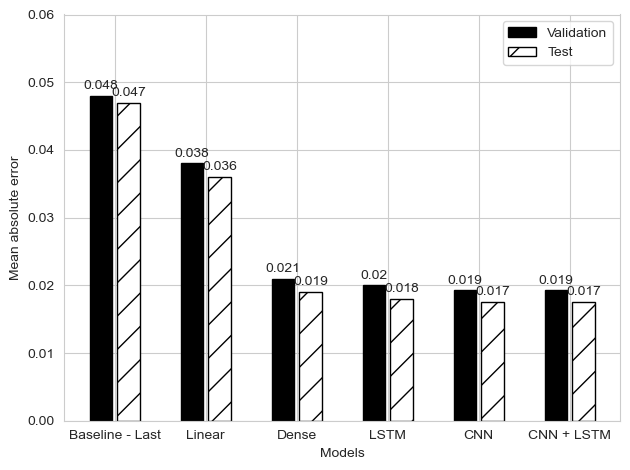

In [52]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

* In this case the CNN models outperform the LSTM model.
* So we can say that CNN models work better with more input feature data.